In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [563]:
n, d = 500, 20
eps = 1e-3
norms = np.concatenate((np.arange(0, 1, 0.25), np.arange(1, 11)))
norm_iter_counts = np.zeros(len(norms))
for i, norm in enumerate(norms):
    embeddings = torch.normal(0, 1, size=(n, d))
    embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)
    embeddings *= norm
    embeddings.requires_grad = True
    embeddings.retain_grad = True
    
    positives = torch.normal(0, 1, size=(n, d))
    positives = positives / torch.norm(positives, dim=-1, keepdim=True)
    positives *= norm
    positives.requires_grad = True
    positives.retain_grad = True
    
    optimizer = torch.optim.SGD([embeddings, positives], lr=10)
    
    iter_count = 0
    cosine_sim = -1 * torch.mean(torch.sum(embeddings * positives, dim=-1)) / norm**2
    while -cosine_sim < 1-eps:
        optimizer.zero_grad()
        cosine_sim.backward()
        optimizer.step()
        
        cosine_sims = -1 * torch.sum(embeddings * positives, dim=-1)
        cosine_sims /= torch.norm(embeddings, dim=-1)
        cosine_sims /= torch.norm(positives, dim=-1)
        cosine_sim = torch.mean(cosine_sims)
        
        iter_count += 1
    print(iter_count)
    norm_iter_counts[i] = iter_count
    

0
6
24
54
96
385
869
1547
2416
3463
4737
6156
7822
9662


In [131]:
interpolations = np.arange(-24, 25) / 25
angle_iter_counts = np.zeros_like(interpolations)
starting_angles = np.zeros_like(interpolations)
for i, interpolation in enumerate(interpolations):
    embeddings = torch.normal(0, 1, size=(n, d))
    embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)
    
    # We now initialize a random positive sample (assuming it has expected angle pi/2 with the embedding)
    #     - we then interpolate between this random positive sample and -1 * embedding with the interpolation constant
    positives = torch.normal(0, 1, size=(n, d))
    positives /= torch.norm(positives, dim=-1, keepdim=True)
    
    positives = positives * (1 - np.abs(interpolation)) - embeddings * interpolation
    positives /= torch.norm(positives, dim=-1, keepdim=True)
    starting_angles[i] = torch.mean(torch.sum(embeddings * positives, dim=-1))
    
    embeddings.requires_grad = True
    embeddings.retain_grad = True
    positives.requires_grad = True
    positives.retain_grad = True
    
    optimizer = torch.optim.SGD([embeddings, positives], lr=10)
    
    iter_count = 0
    cosine_sim = -1 * torch.mean(torch.sum(embeddings * positives, dim=-1))
    while -cosine_sim < 1-eps:
        optimizer.zero_grad()
        cosine_sim.backward()
        optimizer.step()
        
        cosine_sims = -1 * torch.sum(embeddings * positives, dim=-1)
        cosine_sims /= torch.norm(embeddings, dim=-1)
        cosine_sims /= torch.norm(positives, dim=-1)
        cosine_sim = torch.mean(cosine_sims)
        
        iter_count += 1
    print(iter_count)
    angle_iter_counts[i] = iter_count
starting_angles = np.arccos(starting_angles)

0
17
28
37
43
49
54
59
63
66
70
73
76
79
81
83
85
87
88
90
91
92
94
95
96
97
98
99
100
102
102
104
106
107
110
112
114
116
120
123
126
130
134
138
144
150
158
169
187
[0.04061388 0.08443774 0.13229132 0.18451098 0.23975188 0.29882747
 0.36479842 0.43394005 0.50854016 0.58282984 0.66584454 0.75473181
 0.83530477 0.91881859 0.99804429 1.06998542 1.13663107 1.19785946
 1.26479644 1.34675494 1.38683176 1.42361342 1.49063557 1.53876146
 1.57442144 1.61105258 1.65976294 1.69485172 1.76605802 1.81956832
 1.8506825  1.94160859 1.98997925 2.05450588 2.16514558 2.22303317
 2.30939192 2.38560537 2.47700649 2.55987346 2.63581628 2.70987556
 2.7759768  2.84034133 2.90197208 2.95767227 3.00950121 3.05702003
 3.1010008 ]


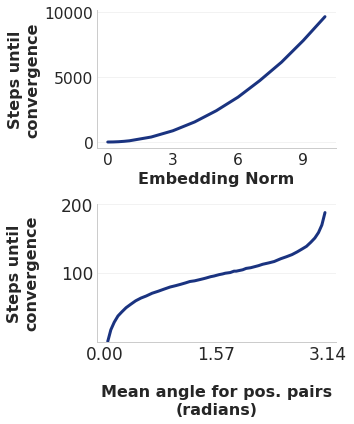

In [677]:
plt.figure(figsize=(5, 6))
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True

blues = [(0.9, 0.9, 1), (0.1, 0.2, 0.5)]  # Light blue to dark blue
blue_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)
colors = [blue_cmap(x) for x in np.linspace(0, 1, 4)]
color = colors[3]

ax = plt.subplot(2, 1, 1)


ax.plot(norms, norm_iter_counts, label='Gradient Descent', linewidth=3, color=color)

#ax.set_title('Embedding-Norm effect', fontsize=16)
xticks = [0, 3, 6, 9]
xlabels = [0, 3, 6, 9]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.tick_params(which='both', labelsize=15.5)
ax.set_xlabel('Embedding Norm', fontsize=16)
ax.set_ylabel('Steps until\nconvergence', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.grid(alpha=0.3, axis='y')

ax = plt.subplot(2, 1, 2)
ax.plot(starting_angles, angle_iter_counts, label='Gradient Descent', linewidth=3, color=color)

#ax.set_title('Opposite-Halves effect', fontsize=16)
xticks = [0, np.pi/2, np.pi]
xlabels = [f'{x:1.2f}' for x in xticks]
ax.set_ylim([0, 200])
ax.set_yticks([100, 200])
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)
ax.tick_params(which='both', labelsize=17)
ax.set_xlabel('\nMean angle for pos. pairs\n(radians)', fontsize=16)
ax.set_ylabel('Steps until\nconvergence\n', fontsize=16)
ax.grid(alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('scratch/bounds.pdf', bbox_inches='tight')
#plt.show()

In [598]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

class SphericalDataset(Dataset):
    def __init__(
        self,
        num_classes=5,
        samples_per_class=1000,
        dim=10, class_weights=None,
        class_vars=None,
        data_dim=64
    ):
        self.num_classes = num_classes
        self.dim = dim
        
        # Generate centers for each class on the unit sphere
        centers = torch.randn(num_classes, dim)
        self.centers = centers / torch.norm(centers, dim=1, keepdim=True)
        
        if class_weights is None:
            class_weights = torch.ones(num_classes)
        if class_vars is None:
            class_vars = torch.ones(num_classes) * 0.1
        class_weights = torch.tensor(class_weights)
        class_weights = class_weights / class_weights.sum()
        
        samples_per_class = torch.multinomial(
            class_weights,
            num_samples=samples_per_class * num_classes,
            replacement=True
        )
        
        self.data = []
        self.labels = []
        self.class_counts = torch.zeros(num_classes)
        
        for class_idx in range(num_classes):
            n_samples = (samples_per_class == class_idx).sum().item()
            self.class_counts[class_idx] = n_samples
            
            noise = torch.randn(n_samples, dim) * class_vars[class_idx]
            points = self.centers[class_idx:class_idx+1].repeat(n_samples, 1) + noise
            points = points / torch.norm(points, dim=1, keepdim=True)
            
            self.data.append(points)
            self.labels.extend([class_idx] * n_samples)
        
        self.data = torch.cat(self.data)
        self.labels = torch.tensor(self.labels)
        
        # Map points from latent classes to data space X with single matrix mult.
        self.observation_matrix = torch.randn(data_dim, dim) * 10 # multiply by ten so that inputs have varied magnitude
        self.observations = self.data @ self.observation_matrix.T
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.observations[idx], self.labels[idx]

class ContrastiveModel(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        
    def forward(self, x):
        return self.encoder(x)
    
def attract_all_infonce_loss(features, labels, temperature=1):
    """
    Supervised InfoNCE loss where all samples from the same class are attracted
    to each other
    """
    features = F.normalize(features, dim=1)
    sim_matrix = torch.matmul(features, features.T) / temperature
    batch_size = features.shape[0]
    
    # Create mask for positive pairs (same class)
    labels = labels.contiguous().view(-1, 1)
    pos_mask = torch.eq(labels, labels.T).float()
    pos_mask.fill_diagonal_(0)  # exclude self-similarity
    
    # Sum up similarities for positive pairs in numerator
    exp_sim = torch.exp(sim_matrix)
    numerator = (exp_sim * pos_mask).sum(dim=1)
    
    # All non-self pairs go in denominator
    diag_mask = torch.eye(batch_size, device=features.device)
    denominator = exp_sim.masked_fill(diag_mask.bool(), 0).sum(dim=1)
    
    # Loss is negative log of (sum of positives / sum of all)
    loss = -torch.log(numerator / denominator + 1e-8)
    return loss.mean()

def attract_pairs_infonce_loss(features, labels, temperature=1):
    """
    Supervised InfoNCE loss where, in each batch, positive pairs are found in accordance
    with the labels. Attractions only occur along the positive pairs.
    """

    features = F.normalize(features, dim=1)
    sim_matrix = torch.matmul(features, features.T) / temperature
    batch_size = features.shape[0]
    
    # Create mask for same-class elements
    labels = labels.contiguous().view(-1, 1)
    same_class_mask = torch.eq(labels, labels.T).float()
    same_class_mask.fill_diagonal_(0)  # exclude self-similarity
    
    # For each element, randomly select one positive pair from same class
    pos_mask = torch.zeros_like(same_class_mask)
    valid_samples = torch.zeros(batch_size, device=features.device, dtype=torch.bool)
    
    for i in range(batch_size):
        # Find indices of same-class elements
        same_class_indices = torch.where(same_class_mask[i] > 0)[0]
        if len(same_class_indices) > 0:
            # Randomly select one positive pair
            positive_idx = same_class_indices[torch.randint(len(same_class_indices), (1,))]
            pos_mask[i, positive_idx] = 1
            pos_mask[positive_idx, i] = 1  # Make it symmetric
            valid_samples[i] = True
            valid_samples[positive_idx] = True
    
    # Calculate loss using single positive pairs
    exp_sim = torch.exp(sim_matrix)
    numerator = (exp_sim * pos_mask).sum(dim=1)
    
    # All non-self pairs go in denominator
    diag_mask = torch.eye(batch_size, device=features.device)
    denominator = exp_sim.masked_fill(diag_mask.bool(), 0).sum(dim=1)
    
    # Loss is negative log of (positive pair / sum of all)
    loss = -torch.log(numerator / denominator + 1e-8)
    
    # Only compute loss for samples that have at least one positive pair
    if valid_samples.any():
        return loss[valid_samples].mean()
    else:
        # Return zero loss if no valid pairs exist
        return torch.tensor(0.0, device=features.device, requires_grad=True)
    
def infonce_loss(features, labels, temperature=1.0, attract_all=False):
    if attract_all:
        return attract_all_infonce_loss(features, labels, temperature)
    return attract_pairs_infonce_loss(features, labels, temperature)


def train_and_analyze(
    dataset,
    model,
    num_epochs=50,
    batch_size=128,
    learning_rate=0.005,
    attract_all=False
):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    norm_history = [[] for i in range(dataset.num_classes)]
    loss_history = []

    # Save norms before any training has occurred
    model.eval()
    embeddings = model(dataset.observations)
    norms = torch.norm(embeddings, dim=1)
    
    for class_idx in range(dataset.num_classes):
        class_mask = dataset.labels == class_idx
        avg_norm = norms[class_mask].mean().item()
        norm_history[class_idx].append(avg_norm)

    # Do training and store off norms
    for epoch in tqdm(range(num_epochs), total=num_epochs):
        total_loss = 0
        model.train()
        
        for batch_idx, (batch_data, batch_labels) in enumerate(dataloader):
            optimizer.zero_grad()
            embeddings = model(batch_data)
            
            if torch.isnan(embeddings).any():
                print(f"NAN detected in embeddings at epoch {epoch}, batch {batch_idx}")
                return norm_history, loss_history
            
            loss = infonce_loss(embeddings, batch_labels, attract_all=attract_all)
            
            if torch.isnan(loss):
                print(f"NAN detected in loss at epoch {epoch}, batch {batch_idx}")
                return norm_history, loss_history
                
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        
        with torch.no_grad():
            model.eval()
            embeddings = model(dataset.observations)
            norms = torch.norm(embeddings, dim=1)
            
            for class_idx in range(dataset.num_classes):
                class_mask = dataset.labels == class_idx
                avg_norm = norms[class_mask].mean().item()
                norm_history[class_idx].append(avg_norm)
    
    return norm_history, loss_history

# Set random seed for reproducibility
torch.manual_seed(42)

In [531]:
# Create uneven class distribution
class_weights = np.array([1, 2, 4, 8])
data_dim = 64
num_runs = 5
latent_dim = 10
imbalance_norm_histories = []
for i in range(num_runs):
    # Create dataset
    imb_dataset = SphericalDataset(
        num_classes=len(class_weights),
        samples_per_class=500,
        dim=latent_dim,
        class_weights=class_weights,
        class_vars=np.ones_like(class_weights),
        data_dim=data_dim,
    )
    
    # Create and train model
    model = ContrastiveModel(input_dim=data_dim, latent_dim=latent_dim)
    norm_history, loss_history = train_and_analyze(imb_dataset, model, num_epochs=100, learning_rate=0.01)
    imbalance_norm_histories.append(norm_history)
imbalance_norm_histories = np.array(imbalance_norm_histories)
imbalance_norm_histories = np.mean(imbalance_norm_histories, axis=0)

100%|██████████| 100/100 [00:10<00:00,  9.54it/s]


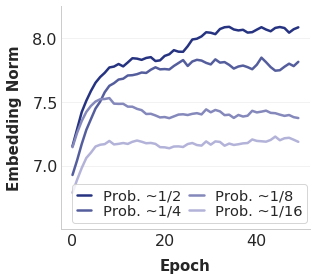

In [688]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Set the style
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

# Create a custom blue colormap
blues = [(0.7, 0.7, 0.85), (0.15, 0.2, 0.5)]  # Light blue to dark blue
blue_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)
colors = [blue_cmap(x) for x in np.linspace(0, 1, dataset.num_classes)]

# Weight strings
weight_strs = ['~1/16', '~1/8', '~1/4', '~1/2']

# First subplot - Class imbalance
for class_idx in np.arange(4)[::-1]:
    ax.plot(
        imbalance_norm_histories[class_idx][:50],
        label=f'Prob. {weight_strs[class_idx]}',
        color=colors[class_idx],
        linewidth=2.5
    )

# Common styling for both plots
ax.set_xlabel('Epoch', fontsize=15, labelpad=10)
ax.set_ylabel('Embedding Norm', fontsize=15, labelpad=10)
ax.set_ylim([6.5, 8.25])
ax.tick_params(axis='both', labelsize=16)
ax.set_yticks([7, 7.5, 8])
ax.grid(alpha=0.3, axis='y')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Position legend inside the plot
ax.legend(loc='upper right', frameon=True, fontsize=14.7,
         bbox_to_anchor=(1.02, 0.235), ncol=2, labelspacing=0.1,
         columnspacing=0.5, borderpad=0.3, handlelength=1)

# Specific labels and titles
ax1.set_ylabel('Mean Embedding Norm', fontsize=17, labelpad=10)
ax1.set_title('Class Imbalance', 
              fontsize=16, pad=20)

# Hide y-tick labels for second plot since they're shared
ax2.tick_params(axis='y', labelright=False)

# Adjust layout
plt.tight_layout()
plt.savefig('scratch/embed_norms_sim.pdf', bbox_inches='tight')

plt.show()

In [603]:
dataset = SphericalDataset(
    num_classes=len(class_weights),
    samples_per_class=500,
    dim=10,
    class_weights=None,
    class_vars=None,
    data_dim=64,
)
latent_points = dataset.data.numpy()
labels = dataset.labels.numpy()

# Create and train model
model = ContrastiveModel(input_dim=data_dim, latent_dim=latent_dim)
train_and_analyze(imb_dataset, model, num_epochs=100, learning_rate=0.01)

# Get embeddings
model.eval()
embeddings = model(dataset.observations).detach().numpy()

/home/andrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
100%|██████████| 100/100 [00:11<00:00,  8.89it/s]


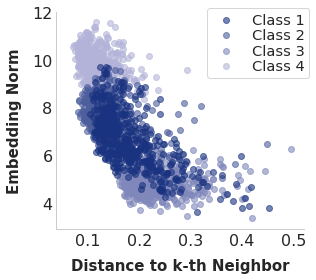

In [701]:
from sklearn.neighbors import NearestNeighbors
normed_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
labels = dataset.labels.numpy()

# Compute k-NN distances
k = 10
nbrs = NearestNeighbors(n_neighbors=k+1).fit(normed_embeddings)  # k+1 because first neighbor is self
distances, _ = nbrs.kneighbors(normed_embeddings)
knn_distances = distances[:, k]  # Get k-th nearest neighbor distance

# Compute embedding norms
embedding_norms = np.linalg.norm(embeddings, axis=1)

# Create scatter plot
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))

# Plot points for each class with different colors
unique_classes = np.unique(labels)
# # Create a custom blue colormap
blues = [(0.7, 0.7, 0.85), (0.1, 0.2, 0.5)]  # Light blue to dark blue
blue_cmap = LinearSegmentedColormap.from_list('custom_blues', blues)
colors = [blue_cmap(x) for x in np.linspace(0, 1, dataset.num_classes)]

for i, class_label in enumerate(unique_classes):
    mask = labels == class_label
    ax.scatter(knn_distances[mask], embedding_norms[mask], 
                c=[colors[i]], label=f'Class {4-class_label}',
                alpha=0.6)

# plt.xlabel('Distance to k-th Nearest Neighbor')
# plt.ylabel('Embedding Norm')
# plt.title('Latent Space Structure vs Embedding Norms')
# plt.legend()
# plt.grid(True, alpha=0.3)

# Common styling for both plots
ax.set_xlabel('Distance to k-th Neighbor', fontsize=15, labelpad=10)
ax.set_ylabel('Embedding Norm', fontsize=15, labelpad=10)
ax.tick_params(axis='both', labelsize=16)
ax.grid(axis='both', alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Position legend inside the plot

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right', frameon=True, fontsize=14.7,
         bbox_to_anchor=(1.05, 1.05), ncol=1, labelspacing=0.1, borderpad=0.3)

# Specific labels and titles
ax1.set_ylabel('Mean Embedding Norm', fontsize=17, labelpad=10)
ax1.set_title('Class Imbalance', 
              fontsize=16, pad=20)

plt.tight_layout()
plt.savefig('scratch/density.pdf', bbox_inches='tight')
plt.show()

/home/andrew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


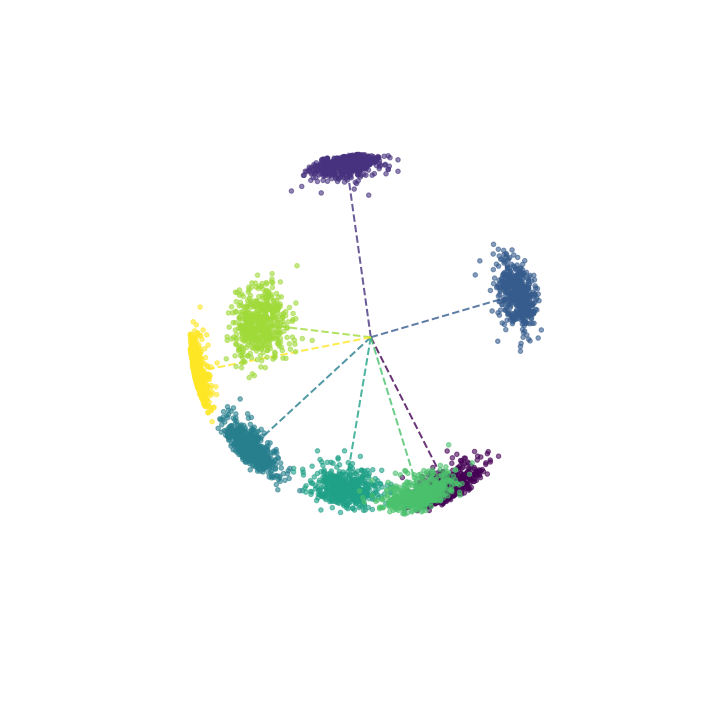

In [734]:
# Visualization of the embedding norms in 3D

latent_dim = 3
num_classes = 8
dataset = SphericalDataset(
    num_classes=num_classes,
    samples_per_class=500,
    dim=latent_dim,
    class_weights=None,
    class_vars=None,
    data_dim=data_dim,
)
labels = dataset.labels

from mpl_toolkits.mplot3d import Axes3D
# Color map for scatter plots
embeddings = dataset.data.numpy()
colors = plt.cm.viridis(np.linspace(0, 1, num_classes))

# Create a single 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each class
for idx, class_label in enumerate(range(num_classes)):
    # Get embeddings for this class
    mask = labels == class_label
    class_embeddings = embeddings[mask]
    
    # Calculate mean vector
    mean_vector = np.mean(class_embeddings, axis=0)
    
    # Plot points
    ax.scatter(class_embeddings[:, 0], 
              class_embeddings[:, 1], 
              class_embeddings[:, 2],
              c=[colors[idx]], alpha=0.6)
    
    # Plot line from origin to mean
    ax.plot([0, mean_vector[0]], 
            [0, mean_vector[1]], 
            [0, mean_vector[2]], 
            '--', color=colors[idx], alpha=0.8, linewidth=2)

ax._axis3don = False

plt.tight_layout()
plt.show()

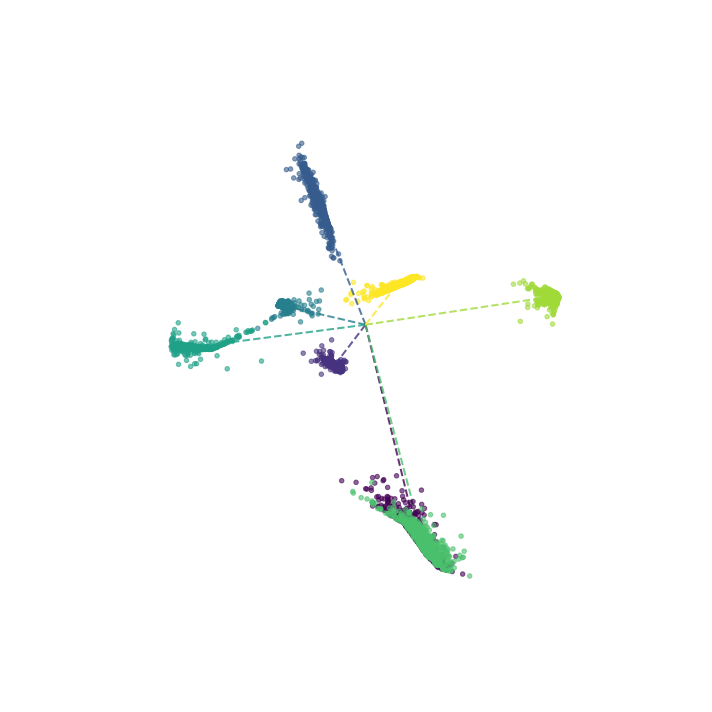

In [737]:
# Create and train model
# model = ContrastiveModel(input_dim=data_dim, latent_dim=latent_dim)
# train_and_analyze(dataset, model, num_epochs=100, learning_rate=0.005)

# model.eval()
# embeddings = model(dataset.observations).detach().numpy()
# labels = dataset.labels

embeddings = model(dataset.observations).detach().numpy()
# embeddings /= np.linalg.norm(embeddings, axis=1, keepdims=True)


from mpl_toolkits.mplot3d import Axes3D
# Color map for scatter plots
colors = plt.cm.viridis(np.linspace(0, 1, num_classes))

# Create a single 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each class
for idx, class_label in enumerate(range(num_classes)):
    # Get embeddings for this class
    mask = labels == class_label
    class_embeddings = embeddings[mask]
    
    # Calculate mean vector
    mean_vector = np.mean(class_embeddings, axis=0)
    
    # Plot points
    ax.scatter(class_embeddings[:, 0], 
              class_embeddings[:, 1], 
              class_embeddings[:, 2],
              c=[colors[idx]], alpha=0.6)
    
    # Plot line from origin to mean
    ax.plot([0, mean_vector[0]], 
            [0, mean_vector[1]], 
            [0, mean_vector[2]], 
            '--', color=colors[idx], alpha=0.8, linewidth=2)

ax._axis3don = False

plt.tight_layout()
plt.show()